In [1]:
%pylab inline

from PyTools import integrated_flux
import os, pres_style

Populating the interactive namespace from numpy and matplotlib


In [2]:
odir = "../inputs/real_deal7/"

u_obf, g_obf, r_obf, i_obf, z_obf, rs_sam = loadtxt("data/Samples/ugriz_catalog_of.txt", usecols=range(1, 6)+[11],
                                                    unpack=True)
u_ref, g_ref, r_ref, i_ref, z_ref = loadtxt("data/Samples/ugriz_catalog_rf.txt", usecols=range(1, 6), unpack=True)

knames = loadtxt("data/Samples/ugriz_catalog_of.txt", dtype=str, usecols=(0,))
mnames = loadtxt("data/RealDeal/rd7_master.txt", dtype=str)
snames = loadtxt("data/RealDeal/rd7_sample.txt", dtype=str)

weff = array([3.5618E+03, 4.7189E+03, 6.1852E+03, 7.4997E+03, 8.9615E+03])
sdss_res = loadtxt("../inputs/SDSS_filters.txt")
u_res = sdss_res[:47]
g_res = sdss_res[47:47+89]
r_res = sdss_res[47+89:47+89+75]
i_res = sdss_res[47+89+75:47+89+75+89]
z_res = sdss_res[47+89+75+89:]

In [4]:
#now remove galaxies not in the actual sample
knames_in_snames = array([name in snames for name in knames], dtype=bool)
mnames_in_snames = array([name in snames for name in mnames], dtype=bool)

print all(knames[knames_in_snames]==snames)
print all(mnames[mnames_in_snames]==snames)

most_rs = rs_sam[knames_in_snames]>=0.09
most_rs[where(most_rs)[0][1000:]] = False # take only the first 1000 galaxies

True
True


In [5]:
icolor_x = u_obf[knames_in_snames] - g_obf[knames_in_snames]
icolor_y = g_obf[knames_in_snames] - r_obf[knames_in_snames]
kcolor_x = u_ref[knames_in_snames] - g_ref[knames_in_snames]
kcolor_y = g_ref[knames_in_snames] - r_ref[knames_in_snames]
redshift = rs_sam[knames_in_snames]

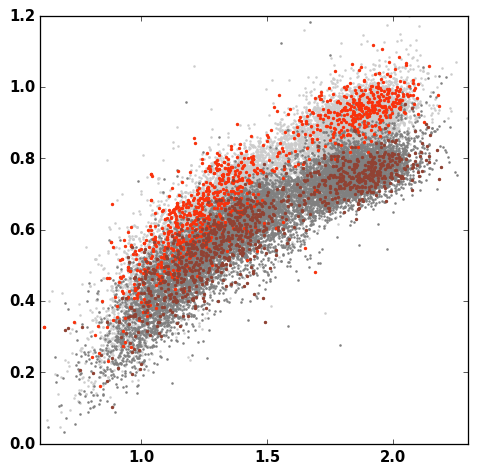

In [6]:
xlm = array((0.6, 2.3))
ylm = array((0.0, 1.2))
axs = subplot(111, xlim=xlm, ylim=ylm)

scatter(icolor_x, icolor_y, lw=0, c="0.8", s=4)
scatter(kcolor_x, kcolor_y, lw=0, c="0.5", s=4)

scatter(icolor_x[most_rs], icolor_y[most_rs], lw=0, c="#F9320C", s=7)
scatter(kcolor_x[most_rs], kcolor_y[most_rs], lw=0, c="#904233", s=7)

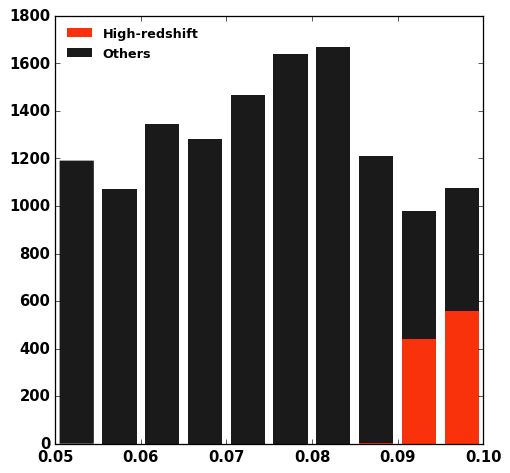

In [7]:
hist([redshift[most_rs], redshift[~most_rs]], histtype="barstacked", color=["#F9320C", "0.1"],
     label=["High-redshift", "Others"])
legend(loc=0, fontsize=10)

In [17]:
sdss, spec = [], []
band = [g_res, r_res, i_res]
for file in snames[most_rs]:
    kflux = loadtxt(odir+"sdss/"+"processed_SDSS_"+file.replace("fit", "txt"), usecols=(1,))
    
    SED = loadtxt(odir+"spec/"+"processed_SPEC_"+file.replace("fit", "txt"), usecols=(0, 1))
    sflux = array([integrated_flux(SED[SED[:, 1]>0.0, :], b) for b in band])

    sdss.append(kflux)
    spec.append(sflux)

sdss = array(sdss)
spec = array(spec)

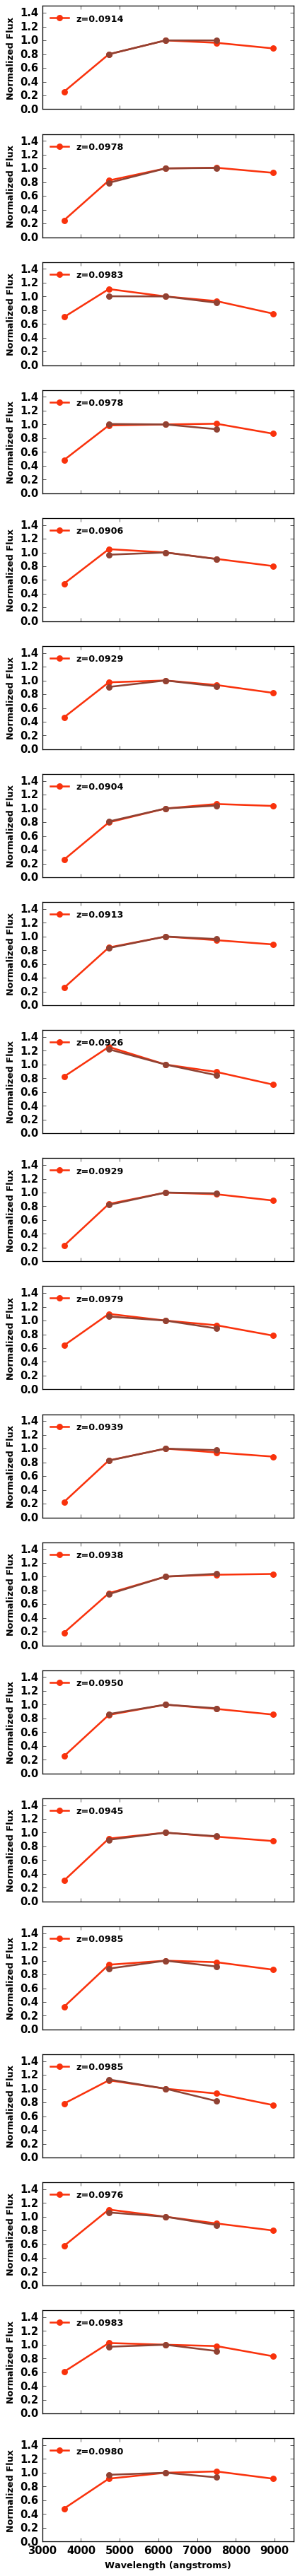

In [38]:
N = 20
fig, axs = subplots(N, 1, sharex=True, sharey=True, figsize=(5, 2*N))

xlim(3000, 9500)
ylim(0.0, 1.5)

for j in xrange(N):
    axs[j].plot(weff, sdss[j]/sdss[j, 2], "o-", color="#F9320C", label="z={0:.4f}".format(redshift[most_rs][j]))
    axs[j].plot(weff[1:-1], spec[j]/spec[j, 1], "o-", color="#904233")

    axs[j].set_ylabel("Normalized Flux", size=10)
    axs[j].legend(loc=2, fontsize=10)

xlabel("Wavelength (angstroms)", size=10)

fig.tight_layout()

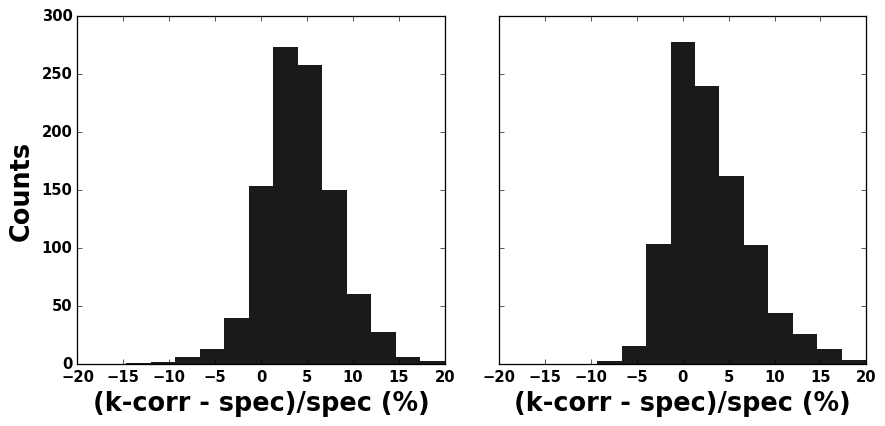

In [54]:
diff = []
for j in [0, 2]:
    diff.append((sdss[:, j+1]/sdss[:, 2]-spec[:, j]/spec[:, 1])*100.0/(spec[:, j]/spec[:, 1]))
diff = array(diff)

fig, axs = subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for j in xrange(axs.size):
    axs[j].hist(diff[j], 15, range=(-20,+20), fc="0.1")
    axs[j].set_xlabel("(k-corr - spec)/spec (%)")

axs[0].set_ylabel("Counts")

fig.tight_layout()